In [1]:
import time
from collections import Counter
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedShuffleSplit
from sklearn import metrics
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

### Load Data

In [2]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [3]:
train.shape, test.shape

((103, 20), (43, 20))

In [4]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [5]:
target = 'poi'
pos_ratio = sum(train[target])/len(train[target])
print('Positive vs negtive ratio on train is %.3f'%pos_ratio)
train.head()

Positive vs negtive ratio on train is 0.117


,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,0.0,178980.0,0.0,0.0,257817.0,3486.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,182466.0,257817.0
1,0.0,0.0,-5104.0,0.0,4046157.0,56301.0,29.0,39.0,0.0,0.0,0.0,864523.0,0,1757552.0,-560222.0,477.0,465.0,566.0,916197.0,5243487.0
2,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,1586055.0,2660303.0,0,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
3,700000.0,0.0,0.0,0.0,0.0,37172.0,4343.0,144.0,386.0,0.0,0.0,566.0,0,126027.0,0.0,231330.0,2639.0,7315.0,969068.0,126027.0
4,5249999.0,2144013.0,-2334434.0,0.0,953136.0,17355.0,484.0,228.0,108.0,0.0,0.0,210698.0,1,157569.0,0.0,213999.0,5521.0,7991.0,5501630.0,1110705.0


Positive example ratio on training set is 0.117


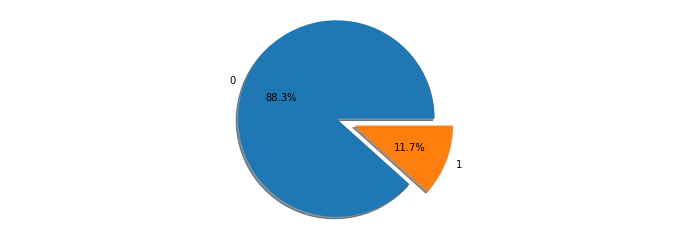

In [6]:
pos_ratio = sum(train[target]) / train.shape[0]
print('Positive example ratio on training set is %.3f'%pos_ratio)
plot_pie(train[target])

### Define funtion for modeling and CV

In [7]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['poi'],eval_metric='auc')
        
    #Predict training and testing set
    dtrain_predictions, dtest_predictions =[alg.predict(X[predictors]) for X in [dtrain, dtest]]
    # binary classification, positive=1, negtive=0, respectively refer to 1 column and 0 column 
    dtrain_pred_prob, dtest_pred_prob = [alg.predict_proba(X[predictors])[:, 1] for X in [dtrain, dtest]]
    #Print model report:
    print("\nModel Report on train dataset!")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['poi'].values, dtrain_predictions))
    print("AUC Score : %f" % metrics.roc_auc_score(dtrain['poi'], dtrain_pred_prob))
    print("\nModel Report on test dataset!")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtest['poi'].values, dtest_predictions))
    print("AUC Score : %f" % metrics.roc_auc_score(dtest['poi'], dtest_pred_prob))
    # Plot feature importance
    xgb.plot_importance(alg)            

### Find the number of estimators at a high learning rate

19

Model Report on train dataset!
Accuracy : 0.9709
AUC Score : 0.993590

Model Report on test dataset!
Accuracy : 0.8605
AUC Score : 0.806306


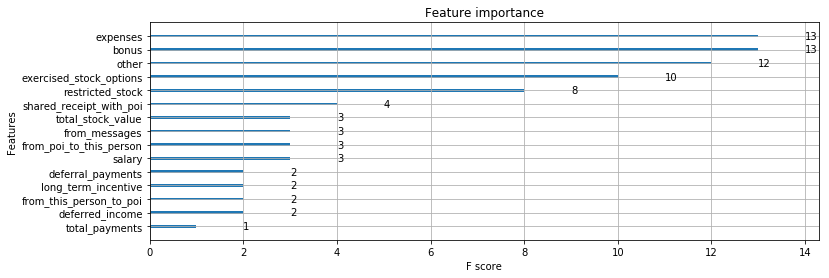

In [8]:
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

In [9]:
### define cv function for convience
def make_CV(model=XGBClassifier(), features=None, labels=None, param_grid=None, scoring='roc_auc', cv=5, verbose=1):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,cv=cv, verbose=verbose, scoring=scoring)
    if features is None or labels is None:
        features, labels = train[predictors], train[target]
    grid_search.fit(features, labels)
    print(grid_search.best_score_)
    print(grid_search.best_params_)

In [10]:
### Grid search on subsample and max_features
tuned_params_1 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':range(1,10,2),
        'min_child_weight':range(1,10,2),
        'gamma':[0],
        'subsample':[0.8],
        'colsample_bytree':[0.8],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1]}
rng = np.random.RandomState(12345)
make_CV(param_grid=tuned_params_1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
0.820956111963
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.8}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   10.9s finished


In [11]:
tuned_params_2 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':[1, 2, 3],
        'min_child_weight':[4, 5, 6],
        'gamma':[0],
        'subsample':[0.8],
        'colsample_bytree':[0.8],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1]}
make_CV(param_grid=tuned_params_2)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.820956111963
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.8}


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.9s finished


### Tune gama

In [12]:
tuned_params_3 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':np.linspace(0,1,5),
        'subsample':[0.8],
        'colsample_bytree':[0.8],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1]}
make_CV(param_grid=tuned_params_3)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.822843922103
{'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.8}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.1s finished


16

Model Report on train dataset!
Accuracy : 0.8835
AUC Score : 0.913462

Model Report on test dataset!
Accuracy : 0.8605
AUC Score : 0.747748


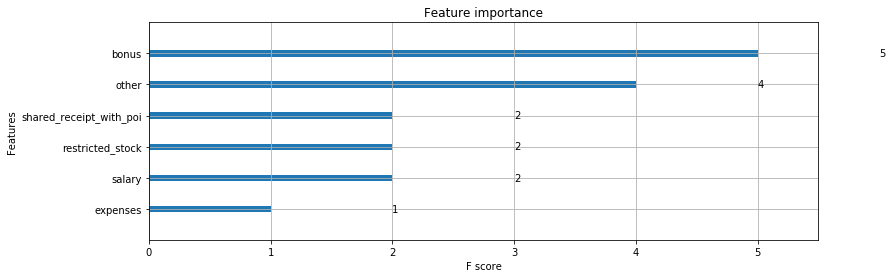

In [13]:
xgb2 = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1, min_child_weight=5, gamma=1, subsample=0.8, 
                     colsample_bylevel=0.8, objective='binary:logistic', scale_pos_weight=1)
predictors = [x for x in train.columns if x not in [target]]
modelfit(xgb2, train, test, predictors)


### Tune subsample and colsample_bytree

In [14]:
tuned_params_4 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':[1],
        'subsample':np.linspace(0.5,1,5),
        'colsample_bytree':np.linspace(0.5,1,5),
        'objective':['binary:logistic'],
        'scale_pos_weight':[1]}
make_CV(param_grid=tuned_params_4)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
0.840331005507
{'colsample_bytree': 0.75, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.625}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   10.0s finished


In [15]:
tuned_params_5 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':[1],
        'subsample':np.linspace(0.5,0.7,5),
        'colsample_bytree':np.linspace(0.6,0.8,5),
        'objective':['binary:logistic'],
        'scale_pos_weight':[1]}
make_CV(param_grid=tuned_params_5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
0.852254016919
{'colsample_bytree': 0.69999999999999996, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.64999999999999991}


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   10.2s finished


### Try regularization

In [16]:
tuned_params_6 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':[1],
        'subsample':[0.65],
        'colsample_bytree':[0.7],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1],
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
make_CV(param_grid=tuned_params_6)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.852254016919
{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_alpha': 1e-05, 'scale_pos_weight': 1, 'subsample': 0.65}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.0s finished


In [17]:
tuned_params_7 ={
        'learning_rate':[0.1],
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':[1],
        'subsample':[0.65],
        'colsample_bytree':[0.7],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1],
        'reg_alpha':[10**x for x in range(-8,-3)]}
make_CV(param_grid=tuned_params_7)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.852254016919
{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_alpha': 1e-08, 'scale_pos_weight': 1, 'subsample': 0.65}


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.0s finished


10

Model Report on train dataset!
Accuracy : 0.8835
AUC Score : 0.894689

Model Report on test dataset!
Accuracy : 0.8605
AUC Score : 0.790541


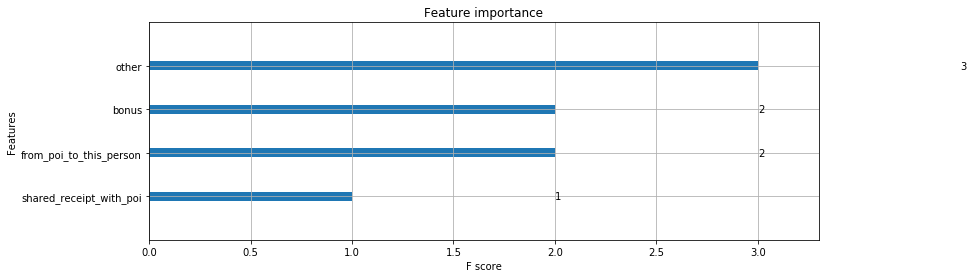

In [18]:
xgb3 = XGBClassifier(n_estimators=5000, learning_rate=0.1, max_depth=1, min_child_weight=5, gamma=1, subsample=0.65, 
                     colsample_bylevel=0.7, objective='binary:logistic', scale_pos_weight=1)
predictors = [x for x in train.columns if x not in [target]]
modelfit(xgb3, train, test, predictors)

In [19]:
tuned_params_8 ={
        'learning_rate':np.linspace(0.01,0.5,10),
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':[1],
        'subsample':[0.65],
        'colsample_bytree':[0.7],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1],
        'reg_alpha':[0]}
make_CV(param_grid=tuned_params_8)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.83317719866
{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.33666666666666667, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_alpha': 0, 'scale_pos_weight': 1, 'subsample': 0.65}


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.0s finished


In [20]:
tuned_params_9 = {
        'learning_rate':np.linspace(0.25,0.4,20),
        'n_estimators':[1000],
        'max_depth':[1],
        'min_child_weight':[5],
        'gamma':[1],
        'subsample':[0.65],
        'colsample_bytree':[0.7],
        'objective':['binary:logistic'],
        'scale_pos_weight':[1],
        'reg_alpha':[0]}
make_CV(param_grid=tuned_params_9)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.851927553512
{'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.30526315789473685, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_alpha': 0, 'scale_pos_weight': 1, 'subsample': 0.65}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.1s finished


4

Model Report on train dataset!
Accuracy : 0.8835
AUC Score : 0.897436

Model Report on test dataset!
Accuracy : 0.8605
AUC Score : 0.756757


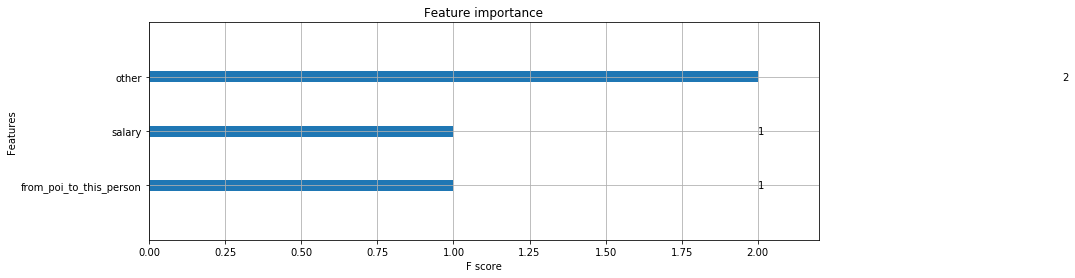

In [21]:
xgb4 = XGBClassifier(n_estimators=1000, learning_rate=0.305, max_depth=1, min_child_weight=5, gamma=1, subsample=0.65, 
                     colsample_bylevel=0.7, objective='binary:logistic', scale_pos_weight=1)
predictors = [x for x in train.columns if x not in [target]]
modelfit(xgb4, train, test, predictors)